# Previsão de churn (abandono) em telecom

### Referências:
- https://github.com/RomeroBarata/IF702-redes-neurais

### Grupo 8:
- Erbert Gadelha (ebgr)
- João Pedro (jpba)
- Vinicius Barbosa (vrb)
- Almir Alves (aasc)
- Felipe Mateus (fmfb)

# Preparação e importação da base de dados

In [48]:
import kagglehub
import numpy as np
import numpy.typing as npt
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, mean_squared_error

!pip install scipy==1.11.4 scikit-plot
import scikitplot as skplt

!pip install optuna
import optuna

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
#@title Download data and create DataFrame
churn_data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", churn_data_path)

churn_df = pd.read_csv(churn_data_path + "/customer_churn_telecom_services.csv")
print(f"Data shape {churn_df.shape}")
churn_df.head()

Path to dataset files: /kaggle/input/customers-churned-in-telecom-services
Data shape (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploração dos dados

### Descrição das colunas:

| Column Name | Description |
|-------------|-------------|
| gender | Customer's gender (Male/Female) |
| SeniorCitizen |	Indicates if the customer is a senior citizen (1 = Yes, 0 = No) |
| Partner | Whether the customer has a partner (Yes/No) |
| Dependents | Whether the customer has dependents (Yes/No) |
|tenure |	Number of months the customer has stayed with the company |
|PhoneService |	Whether the customer has a phone service (Yes/No) |
|MultipleLines | Whether the customer has multiple phone lines (No, Yes, No phone service) |
|InternetService | Type of internet service (DSL, Fiber optic, No) |
|OnlineSecurity |	Whether the customer has online security (Yes, No, No internet service) |
|OnlineBackup |	Whether the customer has online backup (Yes, No, No internet service) |
|DeviceProtection |	Whether the customer has device protection (Yes, No, No internet service) |
|TechSupport | Whether the customer has tech support (Yes, No, No internet service) |
|StreamingTV | Whether the customer has streaming TV (Yes, No, No internet service) |
|StreamingMovies |	Whether the customer has streaming movies (Yes, No, No internet service) |
|Contract |	Type of contract (Month-to-month, One year, Two year) |
|PaperlessBilling |	Whether the customer has paperless billing (Yes/No) |
|PaymentMethod | Payment method used (Electronic check, Mailed check, Bank transfer, Credit card) |
|MonthlyCharges |	Monthly charges the customer pays |
|TotalCharges |	Total amount charged to the customer |
|Churn |	Whether the customer has churned (Yes/No) |

## Verificando valores nulos

In [4]:
#@title Verificando o dataset
churn_df.info()
nulls = churn_df['TotalCharges'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


A colunas `TotalCharges` possui 11 valores nulos, portanto essas amostras serão removidas.

In [5]:
#@title Removendo valores nulos
print(f"Data shape (before cleaning) {churn_df.shape}")
churn_df = churn_df.dropna()
print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7043, 20)
Data shape (after cleaning) (7032, 20)


## Verificando outliers

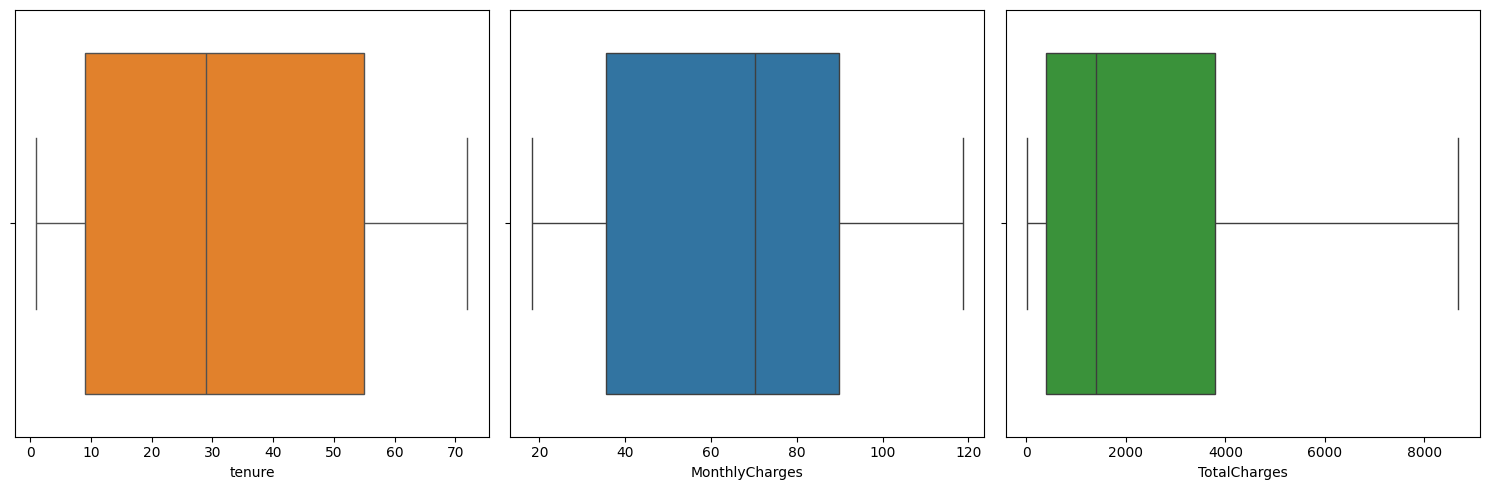

In [6]:
#@title Verificando a existência de outliers

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['tab:orange', 'tab:blue', 'tab:green']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.boxplot(churn_df, x=feature, ax=axes[i], color=colors[i])
plt.tight_layout()

## Analisando distribuições

### Features Contínuas

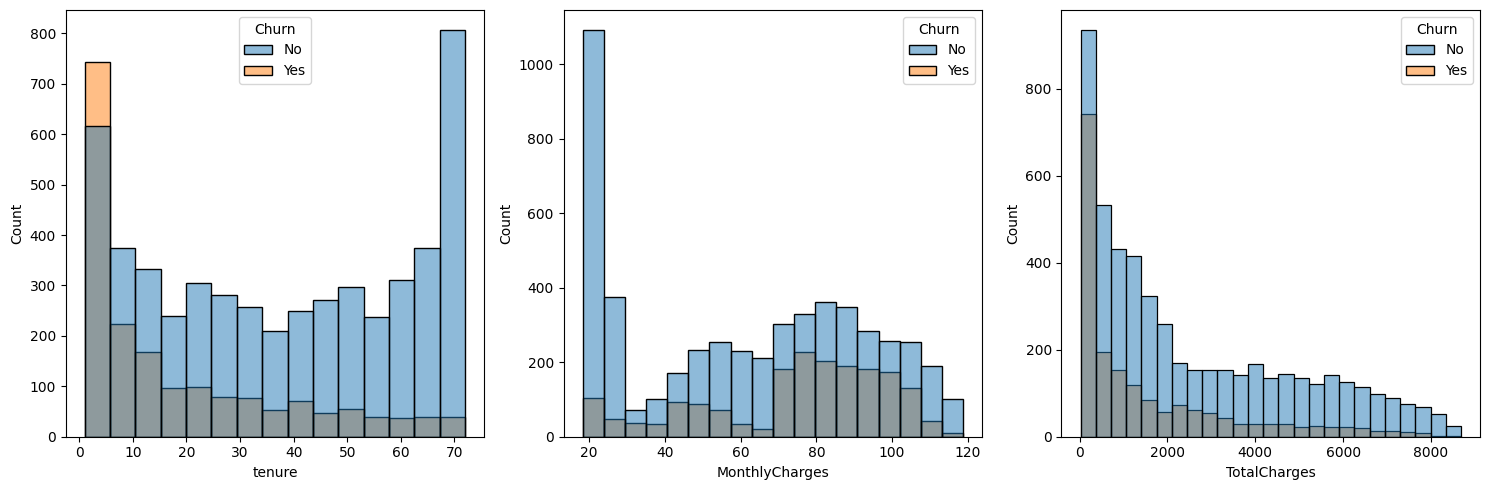

In [7]:
#@title Histograma por abandono

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.histplot(churn_df, x=feature, ax=axes[i], hue='Churn')
plt.tight_layout()
plt.show()

A partir das distribuições podemos deduzir os seguintes pontos:
*   Clientes jovens tendem a abandonar mais, enquanto pessoas com mais idade tendem a continuar sendo clientes
*   Cobranças mensais muito baixas contribuem para uma alta taxa de fidelidade, mas valores mais altos não apresentam uma influência notável



# Preparação dos dados

In [8]:
#@title Convertendo tipos categóricos

cat_df = churn_df.select_dtypes(include=['object', 'category'])
for col in cat_df.columns:
  churn_df[col] = churn_df[col].astype('category')
  churn_df[col] = churn_df[col].cat.codes

  if col == 'Churn':
    continue

  # one hot encode if more than 2 alternatives
  if len(churn_df[col].unique()) > 2:
    churn_df = pd.concat([churn_df, pd.get_dummies(churn_df[col], prefix=col)], axis=1)
    churn_df = churn_df.drop(columns=[col])

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   int8   
 1   SeniorCitizen       7032 non-null   int64  
 2   Partner             7032 non-null   int8   
 3   Dependents          7032 non-null   int8   
 4   tenure              7032 non-null   int64  
 5   PhoneService        7032 non-null   int8   
 6   PaperlessBilling    7032 non-null   int8   
 7   MonthlyCharges      7032 non-null   float64
 8   TotalCharges        7032 non-null   float64
 9   Churn               7032 non-null   int8   
 10  MultipleLines_0     7032 non-null   bool   
 11  MultipleLines_1     7032 non-null   bool   
 12  MultipleLines_2     7032 non-null   bool   
 13  InternetService_0   7032 non-null   bool   
 14  InternetService_1   7032 non-null   bool   
 15  InternetService_2   7032 non-null   bool   
 16  OnlineSecur

In [9]:
#@title Divisão estratificada Treino / Validação / Teste (50% / 25% / 25%)
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train shape {X_train.shape}")
print(f"Validation shape {X_val.shape}")
print(f"Test shape {X_test.shape}")

Train shape (3516, 40)
Validation shape (1758, 40)
Test shape (1758, 40)


In [10]:
#@title Normalização das features numéricas

mean_train = X_train.mean()
std_train = X_train.std()

X_train_n = X_train.copy(deep=True)
X_val_n = X_val.copy(deep=True)
X_test_n = X_test.copy(deep=True)

for col in numerical_features:
  X_train_n[col] = (X_train[col] - mean_train[col]) / std_train[col]
  X_val_n[col] = (X_val[col] - mean_train[col]) / std_train[col]
  X_test_n[col] = (X_test[col] - mean_train[col]) / std_train[col]

print("===========================================================================")
print("Distribuições do conjunto de treino")
print("===========================================================================")
print(X_train.describe())
print("===========================================================================")
print("Distribuições (normalizadas) do conjunto de treino")
print("===========================================================================")
print(X_train_n.describe())

Distribuições do conjunto de treino
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  3516.000000    3516.000000  3516.000000  3516.000000  3516.000000   
mean      0.503982       0.165529     0.483788     0.300910    32.577361   
std       0.500055       0.371710     0.499808     0.458719    24.400907   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
count   3516.000000       3516.000000     3516.000000   3516.000000  
mean       0.905575          0.593572       65.079238   2304.446217  
std        0.292461          0.491236       30.200006   2264.169199  

# Métodos auxiliares

In [22]:
#@title Plot do Teste Kolmogorov-Smirnov

def plot_ks(y_true: npt.NDArray, y_pred: npt.NDArray):
  skplt.metrics.plot_ks_statistic(y_true, y_pred)
  plt.show()

In [12]:
#@title Plot da Matriz de Confusão

def plot_conf_matrix(cm):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [13]:
#@title Plot da curva ROC

def plot_roc(fpr, tpr, auc, label):
  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
  plt.plot([0, 1], [0, 1], '--', color='tab:orange')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

In [14]:
#@title Plot das curvas de erro do treinamento

def plot_training_error_curves(history, loss):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel=f'Loss ({loss})')
    ax.legend()
    plt.show()

# Execução inicial com classificadores

In [15]:
#@title Parâmetros gerais
epochs = 10000
patience = 20

## MLP

In [16]:
#@title Definição do modelo
mlp_classifier = Sequential()
mlp_classifier.add(Input(shape=(X_train.shape[1],)))
mlp_classifier.add(Dense(10, activation='relu'))
mlp_classifier.add(Dense(1, activation='sigmoid'))
mlp_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
mlp_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421 (1.64 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#@title Treinamento inicial
mlp_history = mlp_classifier.fit(X_train_n, y_train, epochs=epochs, validation_data=(X_val_n, y_val),
                                 callbacks=[EarlyStopping(patience=patience, monitor='val_loss')])

Epoch 1/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2298 - val_loss: 0.1641
Epoch 2/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1530 - val_loss: 0.1508
Epoch 3/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419 - val_loss: 0.1471
Epoch 4/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1376 - val_loss: 0.1451
Epoch 5/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1350 - val_loss: 0.1440
Epoch 6/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1333 - val_loss: 0.1432
Epoch 7/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1320 - val_loss: 0.1425
Epoch 8/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1310 - val_loss: 0.1422
Epoch 9/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1303 - val_loss: 0.1419
Epoch 10/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1298 - val_loss: 0.1417
Epoch 11/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1294 - val_loss: 0.1416
Epoch 12/10000
110

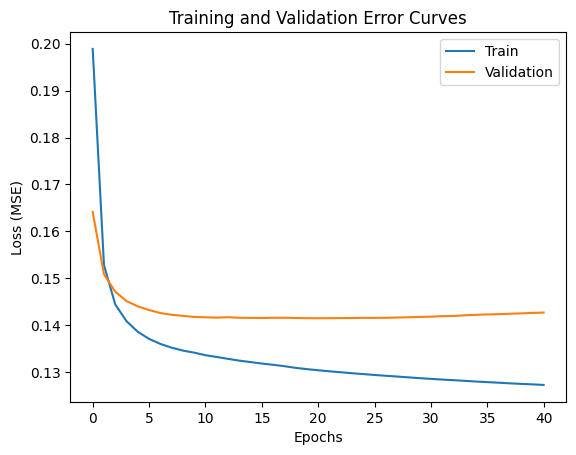

In [18]:
#@title Curvas de aprendizado

plot_training_error_curves(mlp_history, 'MSE')

### Avaliação inicial

In [25]:
#@title Gerando predições
mlp_preds = mlp_classifier.predict(X_test_n)
mlp_preds_scores_0 = 1 - mlp_preds
mlp_preds_scores = np.concatenate([mlp_preds_scores_0, mlp_preds], axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


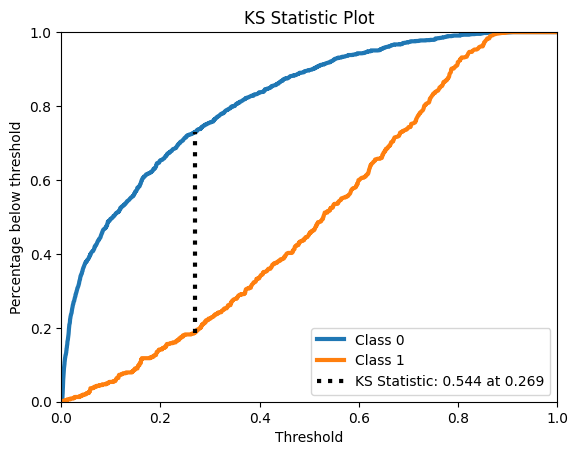

In [27]:
#@title Teste Kolmogorov-Smirnov
plot_ks(y_test, mlp_preds_scores)

In [28]:
#@title MSE
mlp_mse = mlp_classifier.evaluate(X_test_n, y_test, verbose=0)
print(f"MSE: {mlp_mse}")

MSE: 0.13537631928920746


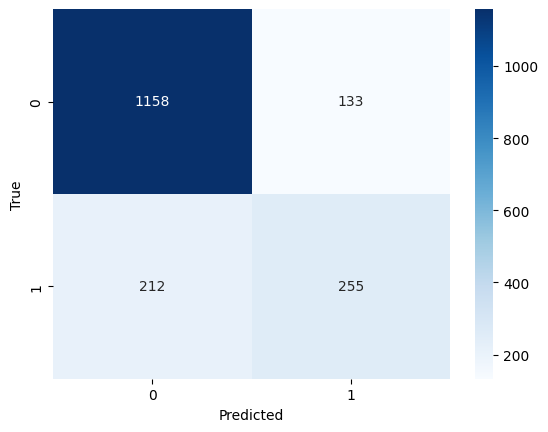

In [29]:
#@title Matriz de confusão
mlp_cm = confusion_matrix(y_test, np.round(mlp_preds))
plot_conf_matrix(mlp_cm)

AUC-ROC: 0.8459662264035152


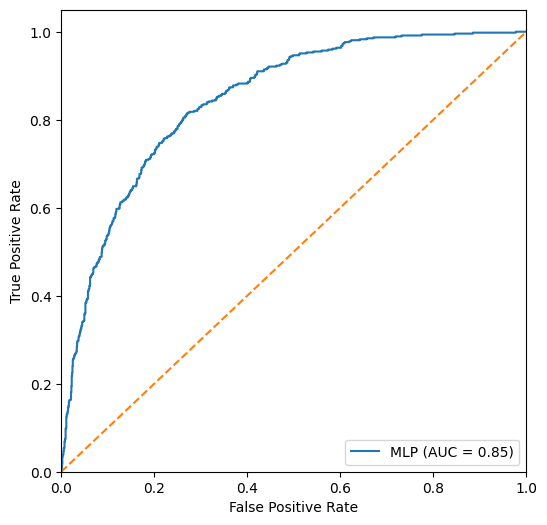

In [30]:
#@title AUC-ROC
mlp_auc = roc_auc_score(y_test, mlp_preds)
print(f"AUC-ROC: {mlp_auc}")
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_preds)
plot_roc(mlp_fpr, mlp_tpr, mlp_auc, 'MLP')

In [31]:
#@title Recall, precision e f-score
mlp_recall = recall_score(y_test, np.round(mlp_preds))
mlp_precision = precision_score(y_test, np.round(mlp_preds))
mlp_f1 = f1_score(y_test, np.round(mlp_preds))
print(f"Recall: {mlp_recall}")
print(f"Precision: {mlp_precision}")
print(f"F1-score: {mlp_f1}")

Recall: 0.5460385438972163
Precision: 0.6572164948453608
F1-score: 0.5964912280701754


## Random Forest

In [32]:
#@title Definição do modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier

RandomForestClassifier(random_state=42)

In [33]:
#@title Treinamento inicial
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Avaliação inicial

In [34]:
#@title Gerando predições
rf_preds = rf_classifier.predict(X_test)
rf_preds_0 = 1 - rf_preds
rf_preds_scores = np.concatenate([rf_preds_0.reshape(-1, 1), rf_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {rf_preds.shape}")

Predições: (1758,)


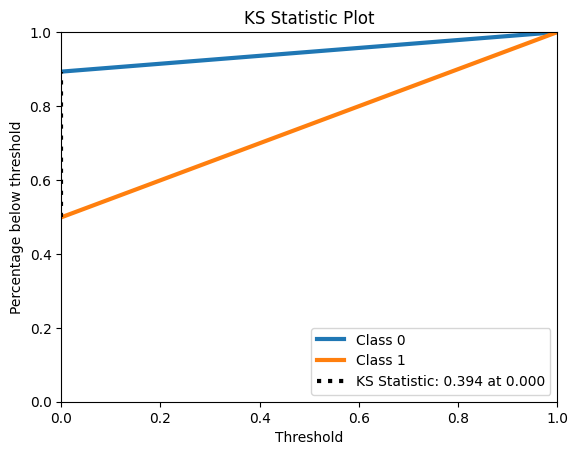

In [35]:
#@title Teste Kolmogorov-Smirnov
rf_ks = plot_ks(y_test, rf_preds_scores)

In [36]:
#@title MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print(f"MSE: {rf_mse}")

MSE: 0.21103526734926054


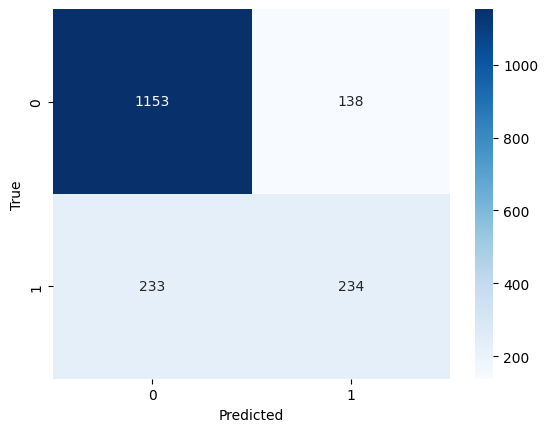

In [37]:
#@title Matriz de confusão
rf_cm = confusion_matrix(y_test, rf_preds)
plot_conf_matrix(rf_cm)

AUC-ROC: 0.6970883915494687


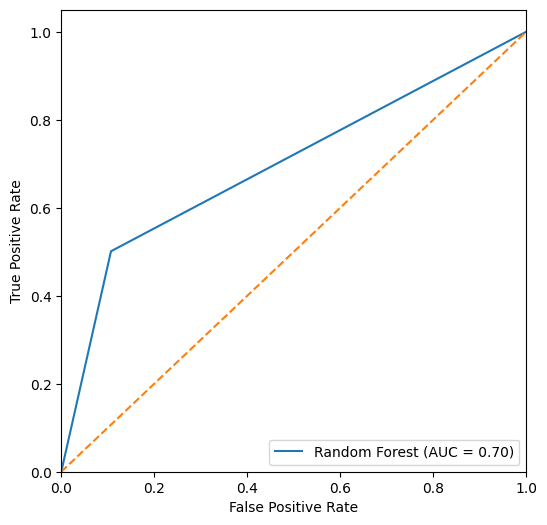

In [38]:
#@title AUC-ROC
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"AUC-ROC: {rf_auc}")
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_preds)
plot_roc(rf_fpr, rf_tpr, rf_auc, 'Random Forest')

In [39]:
#@title Recall, precision e f-score
rf_recall = recall_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
print(f"Recall: {rf_recall}")
print(f"Precision: {rf_precision}")
print(f"F1-score: {rf_f1}")

Recall: 0.5010706638115632
Precision: 0.6290322580645161
F1-score: 0.5578069129916567


# Otimizando classificadores iniciais

## MLP

In [ ]:
#@title Otimização do MLP com Optuna

# A função de otimização para o MLP
def objective_mlp(trial):
    """
    Essa função tem o mesmo 'objetivo' da sua versão RF abaixo
    """

    model = Sequential() #modelo sequencial

    n_layers = trial.suggest_int('n_layers', 1, 2)

    #As n layers são adicionadas de acordo com os hiperparametros escolhidos
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 10, 100)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'sigmoid'])#funções de ativação mais comuns
        model.add(Dense(n_units, activation=activation))

        #adiciona a camada de dropout
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    #adiciona a camada de saída
    model.add(Dense(1, activation='sigmoid'))

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = Adam(learning_rate=learning_rate)
    loss = trial.suggest_categorical('loss', ['mse', 'binary_crossentropy']) # variando entre mse e cross-entropy

    #compilando o modelo 'treinado'
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['AUC'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=10000,
              callbacks=[early_stopping],
              verbose=0)

    #avaliação do modelo
    val_auc = model.evaluate(X_val, y_val, verbose=0)[1]

    return val_auc

#otimização pelo optuna
print("Iniciando a busca pelos hiperparametros do MLP...")
study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=50)#numero de tentativas para o MLP = 50 mas pode ser mudada

print("\n------------------Resultados da Otimização do MLP--------------------------")
print("Melhores hiperparametros encontrados:")
print(study_mlp.best_params)
print("\nMelhor area AUC no conjunto de validação:")
print(study_mlp.best_value)

[I 2025-08-07 23:32:29,582] A new study created in memory with name: no-name-027cdb7f-f3cc-46e3-b68d-bfc9ed5f57f1


Iniciando a busca pelos hiperparametros do MLP...


[I 2025-08-07 23:33:25,559] Trial 0 finished with value: 0.8385553359985352 and parameters: {'n_layers': 1, 'n_units_l0': 57, 'activation_l0': 'relu', 'dropout_l0': 0.03052035353256749, 'learning_rate': 0.002518310989753292, 'loss': 'binary_crossentropy'}. Best is trial 0 with value: 0.8385553359985352.
[I 2025-08-07 23:34:25,049] Trial 1 finished with value: 0.8407016396522522 and parameters: {'n_layers': 1, 'n_units_l0': 43, 'activation_l0': 'sigmoid', 'dropout_l0': 0.015426292619111659, 'learning_rate': 0.0005643413086680889, 'loss': 'binary_crossentropy'}. Best is trial 1 with value: 0.8407016396522522.
[I 2025-08-07 23:34:39,508] Trial 2 finished with value: 0.6128882169723511 and parameters: {'n_layers': 1, 'n_units_l0': 21, 'activation_l0': 'relu', 'dropout_l0': 0.48776604276374963, 'learning_rate': 0.00019852742493667248, 'loss': 'binary_crossentropy'}. Best is trial 1 with value: 0.8407016396522522.
[I 2025-08-07 23:34:57,442] Trial 3 finished with value: 0.5 and parameters: {


------------------Resultados da Otimização do MLP--------------------------
Melhores hiperparametros encontrados:
{'n_layers': 1, 'n_units_l0': 43, 'activation_l0': 'sigmoid', 'dropout_l0': 0.015426292619111659, 'learning_rate': 0.0005643413086680889, 'loss': 'binary_crossentropy'}

Melhor area AUC no conjunto de validação:
0.8407016396522522


## Random Forest

In [ ]:
#@title Otimização do Random Forest com Optuna

# A função de otimização de hiperparâmetros.
def objective_rf(trial):
    """
    Eu uso os dados de X e y definidos anteriormente. Para achar os melhores hiperparametros usando essa função objective_rf
    """
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )


    model.fit(X_train, y_train)


    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo Random Forest...")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

print("\n--- Resultados da Otimização do Random Forest ---")
print("Melhores hiperparametros encontrados:")
print(study_rf.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_rf.best_value)

[I 2025-08-08 00:24:10,302] A new study created in memory with name: no-name-75751a28-463f-424a-99dc-8771c12f7d7a


Iniciando a busca pelos hiperparametros do modelo Random Forest...


[I 2025-08-08 00:24:17,700] Trial 0 finished with value: 0.8118451410439925 and parameters: {'n_estimators': 384, 'max_depth': 22, 'max_features': None, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8118451410439925.
[I 2025-08-08 00:24:18,581] Trial 1 finished with value: 0.8331481165107804 and parameters: {'n_estimators': 279, 'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8331481165107804.
[I 2025-08-08 00:24:19,040] Trial 2 finished with value: 0.8295737082785286 and parameters: {'n_estimators': 128, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8331481165107804.
[I 2025-08-08 00:24:20,573] Trial 3 finished with value: 0.8256783497015243 and parameters: {'n_estimators': 389, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8331481165107804.
[I 2025-08-08 00:24:20,734] Trial 4 finished with value: 0.8297727472520182 and parameters: {'


--- Resultados da Otimização do Random Forest ---
Melhores hiperparametros encontrados:
{'n_estimators': 253, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 6}

Melhor Area AUC no conjunto de validação:
0.8345986130300865


# Executando mais classificadores

## STab

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

## TabPFN2 Transformer

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

## Gradient Boosting

### Primeira execução

In [40]:
#@title Definição do modelo
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier

GradientBoostingClassifier(random_state=42)

In [41]:
#@title Treinamento inicial
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

#### Avaliação inicial

In [42]:
#@title Gerando predições
gb_preds = gb_classifier.predict(X_test)
gb_preds_0 = 1 - gb_preds
gb_preds_scores = np.concatenate([gb_preds_0.reshape(-1, 1), gb_preds.reshape(-1, 1)], axis=1)
print(f"Predições: {gb_preds.shape}")

Predições: (1758,)


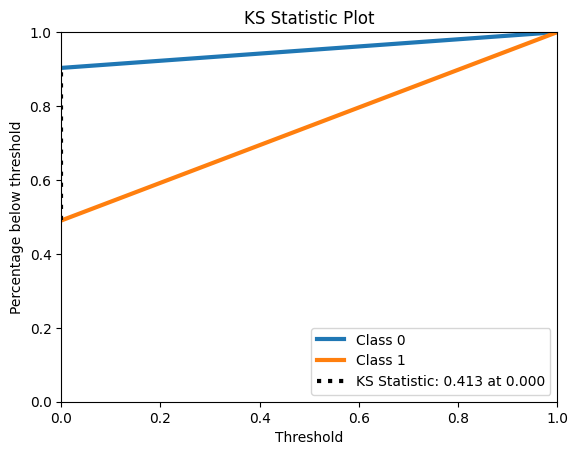

In [44]:
#@title Teste Kolmogorov-Smirnov
gb_ks = plot_ks(y_test, gb_preds_scores)

In [ ]:
#@title MSE
gb_mse = mean_squared_error(y_test, gb_preds)
print(f"MSE: {gb_mse}")

MSE: 0.20136518771331058


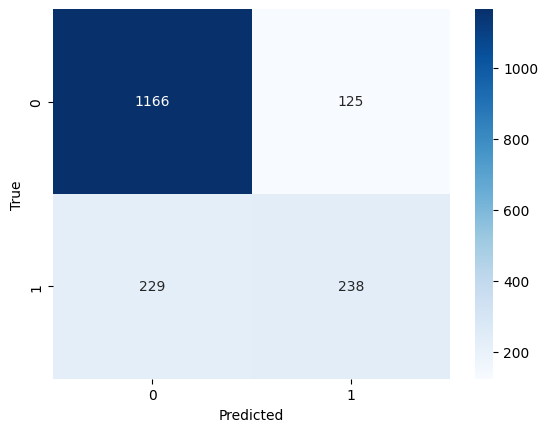

In [45]:
#@title Matriz de confusão
gb_cm = confusion_matrix(y_test, gb_preds)
plot_conf_matrix(gb_cm)

AUC-ROC: 0.7064059034959536


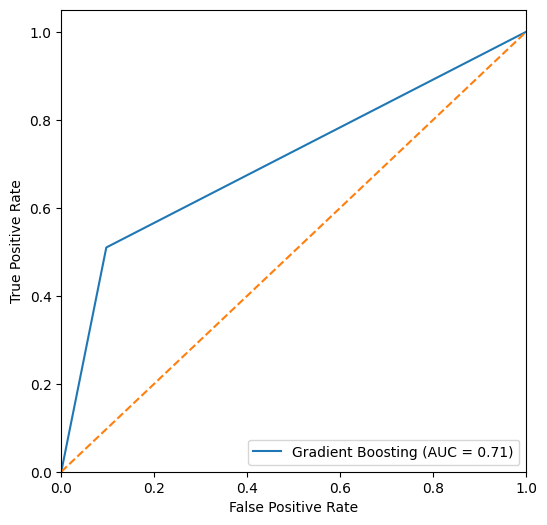

In [46]:
#@title AUC-ROC
gb_auc = roc_auc_score(y_test, gb_preds)
print(f"AUC-ROC: {gb_auc}")
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_preds)
plot_roc(gb_fpr, gb_tpr, gb_auc, 'Gradient Boosting')

In [47]:
#@title Recall, precision e f-score
gb_recall = recall_score(y_test, gb_preds)
gb_precision = precision_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)
print(f"Recall: {gb_recall}")
print(f"Precision: {gb_precision}")
print(f"F1-score: {gb_f1}")

Recall: 0.5096359743040685
Precision: 0.6556473829201102
F1-score: 0.5734939759036145


### Otimizando com o Optuna

In [ ]:
#@title Otimização do Gradient Boosting com Optuna

# A função de otimização de hiperparâmetros.
def objective_gb(trial):
    # Sugere os hiperparâmetros, conforme a especificação do projeto.
    loss = trial.suggest_categorical('loss', ['log_loss', 'exponential'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_depth = trial.suggest_int('max_depth', 2, 32)

    #Aqui pega os melhores parametros achados e utiliza para criar um modelo com esse parametros
    model = GradientBoostingClassifier(
        loss=loss,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        criterion=criterion,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        random_state=42
    )


    model.fit(X_train, y_train)


    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)

    return auc_score

# Cria o estudo do Optuna e executa a otimização
print("Iniciando a busca pelos hiperparametros do modelo Gradient Boosting...")
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=50)

print("\n--- Resultados da Otimização do Gradient Boosting ---")
print("Melhores hiperparametros encontrados:")
print(study_gb.best_params)
print("\nMelhor Area AUC no conjunto de validação:")
print(study_gb.best_value)

[I 2025-08-08 00:45:14,219] A new study created in memory with name: no-name-034f0428-658d-47fd-9021-1df112b40bac


Iniciando a busca pelos hiperparametros do modelo Gradient Boosting...


[I 2025-08-08 00:45:18,513] Trial 0 finished with value: 0.8344924589108919 and parameters: {'loss': 'exponential', 'learning_rate': 0.00010632821982363651, 'n_estimators': 450, 'subsample': 0.5041777019844729, 'criterion': 'squared_error', 'min_samples_leaf': 4, 'max_depth': 6}. Best is trial 0 with value: 0.8344924589108919.
[I 2025-08-08 00:45:21,452] Trial 1 finished with value: 0.8182243401443364 and parameters: {'loss': 'log_loss', 'learning_rate': 0.009095508655468118, 'n_estimators': 104, 'subsample': 0.1656759818790013, 'criterion': 'squared_error', 'min_samples_leaf': 1, 'max_depth': 29}. Best is trial 0 with value: 0.8344924589108919.
[I 2025-08-08 00:45:23,643] Trial 2 finished with value: 0.8335022400177808 and parameters: {'loss': 'exponential', 'learning_rate': 1.0059735726546424e-05, 'n_estimators': 352, 'subsample': 0.10235973966587542, 'criterion': 'friedman_mse', 'min_samples_leaf': 4, 'max_depth': 20}. Best is trial 0 with value: 0.8344924589108919.
[I 2025-08-08 00


--- Resultados da Otimização do Gradient Boosting ---
Melhores hiperparametros encontrados:
{'loss': 'exponential', 'learning_rate': 0.009258504877320406, 'n_estimators': 481, 'subsample': 0.10156490916287331, 'criterion': 'friedman_mse', 'min_samples_leaf': 8, 'max_depth': 2}

Melhor Area AUC no conjunto de validação:
0.8403715725903429


# Avaliação final

## Comparação de métricas de todos os modelos